In [18]:
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms
import numpy as np
#from jax import jit

In [19]:
# plot ellipse

def confidence_ellipse(mu, cov, ax, n_std=3.0, facecolor='none', **kwargs):
    """
    Create a plot of the covariance confidence ellipse of `x` and `y`

    Parameters
    ----------
    x, y : array_like, shape (n, )
        Input data.

    ax : matplotlib.axes.Axes
        The axes object to draw the ellipse into.

    n_std : float
        The number of standard deviations to determine the ellipse's radiuses.

    Returns
    -------
    matplotlib.patches.Ellipse

    Other parameters
    ----------------
    kwargs : `~matplotlib.patches.Patch` properties
    """

    pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])
    # Using a special case to obtain the eigenvalues of this
    # two-dimensionl dataset.
    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    ellipse = Ellipse((0, 0),
        width=ell_radius_x * 2,
        height=ell_radius_y * 2,
        facecolor=facecolor,
        **kwargs)

    # Calculating the stdandard deviation of x from
    # the squareroot of the variance and multiplying
    # with the given number of standard deviations.
    scale_x = np.sqrt(cov[0, 0]) * n_std
    mean_x = mu[0,0]

    # calculating the stdandard deviation of y ...
    scale_y = np.sqrt(cov[1, 1]) * n_std
    mean_y = mu[1,0]

    transf = transforms.Affine2D() \
        .rotate_deg(45) \
        .scale(scale_x, scale_y) \
        .translate(mean_x, mean_y)

    ellipse.set_transform(transf + ax.transData)
    return ax.add_patch(ellipse)

## Update dynamics

In [20]:
def dynamics_step( base_term, state_dot, dt ):
    next_state = base_term + state_dot * dt
#     print(f"next_state:{next_state}")
    return next_state

def dynamics_xdot(state, action = np.array([0])):
    return 100*np.array([np.cos(state[0,0]), np.sin(state[1,0])]).reshape(-1,1)

# assume this is true dynamics
def dynamics_xdot_noisy(state, action = np.array([0])):
    xdot = dynamics_xdot(state, action)
    error_square = 0.01 + np.square(xdot) # /2  #never let it be 0!!!!
    cov = np.diag( error_square[:,0] )
    xdot = xdot + xdot/2 #X_dot = X_dot + X_dot/6
    return xdot, cov

## Compute Moments functions

In [21]:
# @jit
def get_mean( sigma_points, weights ):
    weighted_points = sigma_points * weights[0]
    mu = np.sum( weighted_points, 1 ).reshape(-1,1)
    return mu

# @jit
def get_mean_cov(sigma_points, weights, weights_cov):
    
    # mean
    weighted_points = sigma_points * weights[0]
    mu = np.sum( weighted_points, 1 ).reshape(-1,1)
    
    # covariance
    centered_points = sigma_points - mu
    weighted_centered_points = centered_points * weights_cov[0] 
    cov = weighted_centered_points @ centered_points.T
    return mu, cov

#@jit
def get_ut_cov_root_diagonal(cov):
    k = 0.5#-1
    n = cov.shape[0]
    offset = 0.001
    root0 = np.sqrt((n+k)*(offset+cov[0,0]))
    root1 = np.sqrt((n+k)*(offset+cov[1,1]))
    # return cov
    root_term = np.diag( np.array([root0, root1]) )
    return root_term

# PILCO Update

In [22]:
def pilco_propagate(mean, cov):
    mu, cov = dynamics_xdot_noisy(mean)
    return dynamics_step( mean, mu, dt ), cov * dt**2

# Monte Carlo Update

In [23]:
def mc_propagate(points):
    new_points = np.copy(points)
    for i in range(points.shape[1]):
        mu, cov = dynamics_xdot_noisy(points[:,i].reshape(-1,1))
        sample = np.array([  np.random.normal(mu[0,0], np.sqrt(cov[0,0])), np.random.normal(mu[1,0], np.sqrt(cov[1,1]))  ]).reshape(-1,1) 
        points[:,i] = dynamics_step(points[:,i].reshape(-1,1), sample, dt)[:,0]
    return points

# FORESEE Update

## Expansion and Compression Operations

In [33]:
#@jit
def initialize_sigma_points(X):
    # return 2N + 1 points
    n = X.shape[0]
    num_points = 2*n + 1
    sigma_points = np.repeat( X, num_points, axis=1 )
    weights = np.ones((1,num_points)) * 1.0/( num_points )
    return sigma_points, weights

# @jit
def generate_sigma_points_gaussian( mu, cov_root, base_term, factor ):
    n = mu.shape[0]     
    N = 2*n + 1 # total points

    # k = 1.0#0.5 # n-3 # 0.5**
    
    alpha = 0.1
    beta = 4.0#2.0 # optimal for gaussian
    k = 1.0
    Lambda = alpha**2 * ( n+k ) - n
    new_points = dynamics_step(base_term, mu, factor) # new_points = base_term + factor * mu
    new_weights = np.array([[1.0*Lambda/(n+Lambda)]])    
    new_weights_cov = np.array([[ 1.0*Lambda/(n+Lambda) + 1 - alpha**2 + beta]])
    for i in range(n):
        new_points = np.append( new_points, dynamics_step(base_term, (mu - np.sqrt(n+Lambda) * cov_root[:,i].reshape(-1,1)), factor) , axis = 1 )
        new_points = np.append( new_points, dynamics_step(base_term, (mu + np.sqrt(n+Lambda) * cov_root[:,i].reshape(-1,1)), factor) , axis = 1 )
        new_weights = np.append( new_weights, np.array([[1.0/(n+Lambda)/2.0]]), axis = 1 )
        new_weights = np.append( new_weights, np.array([[1.0/(n+Lambda)/2.0]]), axis = 1 )
        new_weights_cov = np.append( new_weights_cov, np.array([[1.0/(n+Lambda)/2.0]]), axis = 1 )
        new_weights_cov = np.append( new_weights_cov, np.array([[1.0/(n+Lambda)/2.0]]), axis = 1 )
#     print(f"weights1: {new_weights}")
#     print(f"weights2: {new_weights_cov}")
    return new_points, new_weights, new_weights_cov

# @jit
def sigma_point_expand(sigma_points, weights1, weights2, control):
   
    n, N = sigma_points.shape   
    # dt_outer = 0  
    #TODO  
    mu, cov = dynamics_xdot_noisy(sigma_points[:,0].reshape(-1,1), control.reshape(-1,1))
    root_term = get_ut_cov_root_diagonal(cov) 
    temp_points, temp_weights1, temp_weights2 = generate_sigma_points_gaussian( mu, root_term, sigma_points[:,0].reshape(-1,1), dt )
    new_points = np.copy( temp_points )
    new_weights1 = ( np.copy( temp_weights1 ) * weights1[0,0]).reshape(1,-1)
    new_weights2 = ( np.copy( temp_weights2 ) * weights2[0,0]).reshape(1,-1)
        
    for i in range(1,N):
        mu, cov = dynamics_xdot_noisy(sigma_points[:,i].reshape(-1,1), control.reshape(-1,1))
        root_term = get_ut_cov_root_diagonal(cov)           
        temp_points, temp_weights1, temp_weights2 = generate_sigma_points_gaussian( mu, root_term, sigma_points[:,i].reshape(-1,1), dt )
        new_points = np.append(new_points, temp_points, axis=1 )
        new_weights1 = np.append( new_weights1, (temp_weights1 * weights1[0,i]).reshape(1,-1) , axis=1 )
        new_weights2 = np.append( new_weights2, (temp_weights2 * weights2[0,i]).reshape(1,-1) , axis=1 )

    return new_points, new_weights1, new_weights2

#@jit
def sigma_point_compress( sigma_points, weights1, weights2 ):
    mu, cov = get_mean_cov( sigma_points, weights1, weights2 )
    cov_root_term = get_ut_cov_root_diagonal( cov )  
    base_term = np.zeros((mu.shape))
    return generate_sigma_points_gaussian( mu, cov_root_term, base_term, np.array([1.0]) )

def foresee_propagate( sigma_points, weights1, weights2, action = np.array([0]) ):
    
    #Expansion Layer
    expanded_sigma_points, expanded_weights1, expanded_weights2 = sigma_point_expand( sigma_points, weights1, weights2, action )
    
    # Compression layer
    compressed_sigma_points, compressed_weights1, compressed_weights2 = sigma_point_compress(expanded_sigma_points, expanded_weights1, expanded_weights2)
    
    return compressed_sigma_points, compressed_weights1, compressed_weights2, expanded_sigma_points, expanded_weights1, expanded_weights2

In [52]:
# # Sanity check of above function
mu = np.array([1.5, 2.5]).reshape(-1,1)
# cov = np.array([
#     [0.6, 0],
#     [0.0, 3.4]
# ])
mu = np.array([0.075, 0.075]).reshape(-1,1)
cov = np.array([
    [0.00252, 0],
    [0.0, 0.00252]
])
# mu = np.array([1.5]).reshape(-1,1)
# cov = np.array([[1.2]])
cov_root = np.sqrt( cov )

# # p, w = initialize_sigma_points(mu)#, cov)
# # mu1, cov1 = get_mean_cov( p, w, w )
# # print(f"org mu: {mu1}, cov: {cov1}")

points, weights1, weights_cov = generate_sigma_points_gaussian( mu, cov_root, np.zeros((2,1)), 1.0 )
mu2, cov2 = get_mean_cov( points, weights1, weights_cov )
print( f"mean:{mu2}, cov:{cov2}" )
# exit()
weights1

mean:[[0.075]
 [0.075]], cov:[[2.52000000e-03 1.81159116e-31]
 [1.79111485e-31 2.52000000e-03]]


array([[-65.66666667,  16.66666667,  16.66666667,  16.66666667,
         16.66666667]])

# Test Scenario

In [49]:
horizon = 2
dt = 0.05
initial_state_mean = np.array([0.0,0.0]).reshape(-1,1)
initial_state_cov = np.zeros((2,2))
sigma_points_init, weights_init = initialize_sigma_points(initial_state_mean)

# PILCO init
pilco_mu, pilco_cov = np.copy(initial_state_mean), np.copy(initial_state_cov)

# Monte Carlo init
num_particles = 500
mc_particles = np.repeat(initial_state_mean, num_particles, axis=1)

# FORESEE init
sigma_points = np.copy(sigma_points_init)
weights1 = np.copy(weights_init)
weights2 = np.copy(weights_init)

# Initialize data

for t in range(horizon):
    
    # PILCO Update
    pilco_mu, pilco_cov = pilco_propagate(pilco_mu, pilco_cov)

    # Monte Carlo Update
    mc_particles = mc_propagate(mc_particles)    
    
    # FORESEE update
    sigma_points, weights1, weights2, full_sigma_points, full_weights1, full_weights2 = foresee_propagate(sigma_points, weights1, weights2)
    

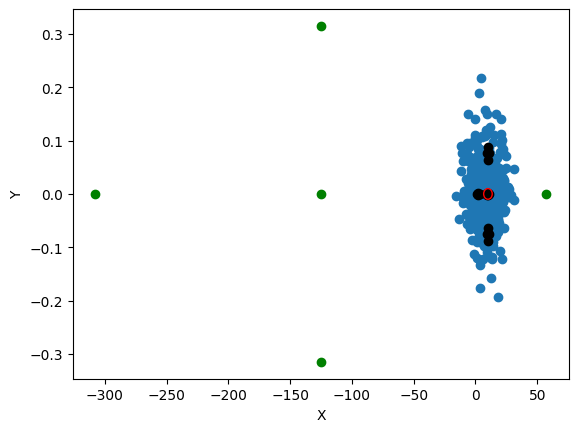

In [50]:
# Visualize
# plt.ion()
fig = plt.figure()
ax = plt.axes()
ax.set_xlabel("X")
ax.set_ylabel("Y")

plot_mc = plt.scatter(mc_particles[0,:], mc_particles[1,:])
plot_foresee = plt.scatter( sigma_points[0,:], sigma_points[1,:], c = 'g' )
plot_foresee2 = plt.scatter( full_sigma_points[0,:], full_sigma_points[1,:], c = 'k' )
plot_pilco = confidence_ellipse( pilco_mu, pilco_cov, ax, n_std=2.0, edgecolor = 'red' )

In [12]:
mc_particles

array([[ 7.57847531e+00,  9.18129485e+00,  9.29951492e+00,
         1.03824425e+01,  5.44877773e+00,  9.91964110e+00,
         1.16616982e+01,  7.01536707e+00,  6.60609262e+00,
         1.21443938e+00,  2.01333205e+00,  4.62583636e+00,
         7.06221048e+00,  1.69462650e+01,  5.24296986e+00,
         6.00466084e+00,  7.38099744e+00,  4.75673776e+00,
         2.05625913e+01,  4.80786053e+00,  2.94869636e+00,
         8.16084859e+00,  3.88130086e+00,  8.46838650e+00,
         4.43299657e-01, -8.19156051e-01,  1.20512467e+01,
         1.33652195e+00,  1.19894994e+01,  1.41232538e+01,
         3.89588105e+00,  1.10983783e+01,  1.31333154e+01,
        -1.08474374e+01,  8.12585225e-01,  5.29004568e+00,
         8.21840537e+00,  1.75513735e+01,  1.99181942e+01,
         9.79836070e+00,  9.73404805e+00,  4.04843298e+00,
         1.29517614e+01,  8.34734655e+00,  1.53521172e+01,
         6.92159076e+00,  5.39861921e+00,  6.50799836e+00,
         1.73136259e+00,  5.44147023e+00,  5.34557152e+0